epoch: 0, loss: 0.5276175486282239
epoch: 500, loss: 0.00033057908065908803
epoch: 1000, loss: 0.002722620006211207
epoch: 1500, loss: 0.001057391792826226
epoch: 2000, loss: 0.0002516506516289929
tensor([0.3536+0.j, 0.3536+0.j, 0.3536+0.j, 0.3536+0.j, 0.3536+0.j, 0.3536+0.j, 0.3536+0.j,
        0.3536+0.j], dtype=torch.complex128, grad_fn=<SqueezeBackward4>)


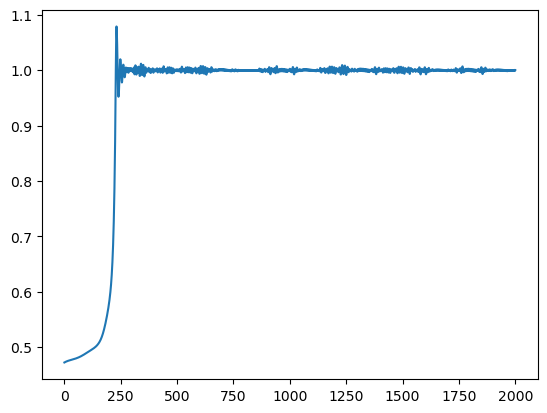

In [5]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset
from torch.nn.parameter import Parameter
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

num_qubits = 8

batch_size = 8

num_epochs = 2001

learning_rate = 1e-3

n = 3
N = 2**n

loss_graph = []

class input_vec_dataset(Dataset):
    def __init__(self):
        
        self.n = n
        self.N = N

        F = torch.zeros((N,N), dtype=torch.complex128)
        w = np.exp(-2*np.pi*1j / N)

        for k in range(N):
            for j in range(N):
                F[j][k] = w**(j*k) / np.sqrt(N)

        dataset = []
        labels = []

        for i in range(num_qubits):
            phi = np.random.rand() * 2*np.pi
            theta = np.random.rand() * np.pi

            input_qubit = torch.tensor([np.sin(theta), np.cos(theta) * np.exp(1j * phi)])
            dataset.append(input_qubit)

            q = input_qubit
            q0 = torch.tensor([1,0], dtype=torch.complex128)

            for i in range(n-1):
                q = torch.kron(q,q0)
            q = q @ F
            labels.append(q)
            
        self.dataset = torch.stack(dataset)
        self.labels = torch.stack(labels)
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        return self.dataset[idx],self.labels[idx]

data_set = input_vec_dataset()

data_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size, shuffle=False, drop_last=False)

class HModel(torch.nn.Module):
    
    def __init__(self):
        super(HModel, self).__init__()
        self.w = Parameter(torch.rand(1, dtype=torch.complex128))
      
    def forward(self, x):
        w = self.w
        
        F = torch.zeros((N,N), dtype=torch.complex128)
        
        for k in range(N):
            for j in range(N):
                F[j][k] = w**(j*k) / np.sqrt(N)
            
        q=x
        
        for i in range(n-1):
            q0 = torch.tensor([1,0], dtype=torch.complex128)
            q = torch.kron(q,q0)
            
        return q @ F
    
model = HModel()

def quantum_infidelity_batched(state_batch, target_state_batch):

    loss = torch.stack([torch.abs(1 - torch.abs(torch.dot(target_state.conj(), state))**2)
                        for state, target_state in zip(state_batch, target_state_batch)]).mean()
    
    fidelity = torch.stack([torch.abs(torch.dot(target_state.conj(), state))**2
                        for state, target_state in zip(state_batch, target_state_batch)]).mean()
    
    loss_graph.append(fidelity.item())
    
    return loss

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    
    for batch, labels in data_loader:
        
        optimizer.zero_grad()
        
        outputs = model(batch)
        
        loss = quantum_infidelity_batched(outputs, labels) 

        loss.backward()
        
        optimizer.step()
        
    if epoch % 500 == 0:
        
        print(f'epoch: {epoch}, loss: {loss}')
        
model.eval()

q_test = torch.tensor([1,0], dtype=torch.complex128)

q_out = model(q_test)

print(q_out)

x_graph = np.arange(num_epochs * num_qubits / batch_size)
plt.plot(x_graph,loss_graph)

In [1]:
#NEW

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset
from torch.nn.parameter import Parameter
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

num_qubits = 8

batch_size = 8

num_epochs = 501

learning_rate = 1e-3

n = 3
N = 2**n

loss_graph = []

class input_vec_dataset(Dataset):
    def __init__(self):
        
        self.n = n
        self.N = N

        F = torch.zeros((N,N), dtype=torch.complex128)
        w = np.exp(-2*np.pi*1j / N)

        for k in range(N):
            for j in range(N):
                F[j][k] = w**(j*k) / np.sqrt(N)

        dataset = []
        labels = []

        for i in range(num_qubits):
            phi = np.random.rand() * 2*np.pi
            theta = np.random.rand() * np.pi

            input_qubit = torch.tensor([np.sin(theta), np.cos(theta) * np.exp(1j * phi)])
            dataset.append(input_qubit)

            q = input_qubit
            q0 = torch.tensor([1,0], dtype=torch.complex128)

            for i in range(n-1):
                q = torch.kron(q,q0)
            q = q @ F
            labels.append(q)
            
        self.dataset = torch.stack(dataset)
        self.labels = torch.stack(labels)
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        return self.dataset[idx],self.labels[idx]

data_set = input_vec_dataset()

data_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size, shuffle=False, drop_last=False)

def elements_to_matrix(matrix_entries: list):
    return torch.stack([torch.stack([value for value in row]) for row in matrix_entries]).squeeze()

def crot(control,target,k):
    r_gate = torch.tensor([[1,0],
                           [0,np.exp(1j*2*np.pi / (2**k))]], dtype=torch.complex128)
    q0 = torch.tensor([1,0], dtype=torch.complex128)
    q1 = torch.tensor([0,1], dtype=torch.complex128)
    
    zeros = torch.outer(q0,q0)
    ones = torch.outer(q1,q1)

    crot = [[i_gate for _ in range(n)] for _ in range(2)]
    
    crot[0][control] = zeros
    
    crot[1][control] = ones
    crot[1][target] = r_gate
    
    a = crot[0][0]
    
    for j in range(n-1):
        a = torch.kron(a,crot[0][j+1])

    b = crot[1][0]
    
    for j in range(n-1):
        b = torch.kron(b,crot[1][j+1])
    return a + b

class HModel(torch.nn.Module):
    
    def __init__(self):
        super(HModel, self).__init__()
        self.θ = Parameter(2 * np.pi * torch.rand(1, dtype=torch.float64))
        self.α = Parameter(2 * np.pi * torch.rand(1, dtype=torch.float64))
        self.β = Parameter(2 * np.pi * torch.rand(1, dtype=torch.float64))
        self.ϕ = Parameter(2 * np.pi * torch.rand(1, dtype=torch.float64))
      
    def forward(self, x):
        θ = self.θ
        α = self.α
        β = self.β
        ϕ = self.ϕ
        
        U = elements_to_matrix(
            [[torch.exp(1j * α) * torch.cos(θ), torch.exp(1j * β) * torch.sin(θ)],
             [- torch.exp(-1j * β) * torch.sin(θ), torch.exp(-1j * α) * torch.cos(θ)]])
        
        QFT_out = []
        
        for a in batch:
            QFT = basis(0,0,0)
            for j in range(n):
                QFT = QFT @ h(j)
                for k in range(n-j-1):
                    QFT = QFT @ crot(j,k+j+1,k+2)
            QFT_out.append(QFT)
        return torch.stack(QFT_out)
        
    
model = HModel()

def quantum_infidelity_batched(state_batch, target_state_batch):

    loss = torch.stack([torch.abs(1 - torch.abs(torch.dot(target_state.conj(), state))**2)
                        for state, target_state in zip(state_batch, target_state_batch)]).mean()
    
    fidelity = torch.stack([torch.abs(torch.dot(target_state.conj(), state))**2
                        for state, target_state in zip(state_batch, target_state_batch)]).mean()
    
    loss_graph.append(fidelity.item())
    
    return loss

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    
    for batch, labels in data_loader:
        
        optimizer.zero_grad()
        
        outputs = model(batch)
        
        loss = quantum_infidelity_batched(outputs, labels) 

        loss.backward()
        
        optimizer.step()
        
    if epoch % 500 == 0:
        
        print(f'epoch: {epoch}, loss: {loss}')
        
model.eval()

q_test = torch.tensor([1,0], dtype=torch.complex128)

q_out = model(q_test)

print(q_out)

x_graph = np.arange(num_epochs * num_qubits / batch_size)
plt.plot(x_graph,loss_graph)

NameError: name 'basis' is not defined

In [23]:
q0 = torch.tensor([1,0], dtype=torch.complex128)
q1 = torch.tensor([0,1], dtype=torch.complex128)

i_gate = torch.tensor([[1,0],
                       [0,1]], dtype=torch.complex128)
x_gate = torch.tensor([[0,1],
                       [1,0]], dtype=torch.complex128)
z_gate = torch.tensor([[1,0],
                       [0,-1]], dtype=torch.complex128)
h_gate = torch.tensor([[1,1],
                       [1,-1]] / np.sqrt(2), dtype=torch.complex128)

def basis(*args):
    basis = []
    for j in args:
        if type(j) == torch.Tensor:
            basis.append(j)
        elif j == 0:
            basis.append(q0)
        elif j == 1:
            basis.append(q1)

    a = basis[0]
    for j in range(len(basis)-1):
        a = torch.kron(a,basis[j+1])
    global n
    n = len(basis)
    return a

def cnot(control,target):
    zeros = torch.outer(q0,q0)
    ones = torch.outer(q1,q1)

    cnot = [[i_gate for _ in range(n)] for _ in range(2)]
    
    cnot[0][control] = zeros
    
    cnot[1][control] = ones
    cnot[1][target] = x_gate
    
    a = cnot[0][0]
    
    for j in range(n-1):
        a = torch.kron(a,cnot[0][j+1])

    b = cnot[1][0]
    
    for j in range(n-1):
        b = torch.kron(b,cnot[1][j+1])
    return a + b

def crot(control,target,k):
    r_gate = torch.tensor([[1,0],
                           [0,np.exp(1j*2*np.pi / (2**k))]], dtype=torch.complex128)

    zeros = torch.outer(q0,q0)
    ones = torch.outer(q1,q1)

    crot = [[i_gate for _ in range(n)] for _ in range(2)]
    
    crot[0][control] = zeros
    
    crot[1][control] = ones
    crot[1][target] = r_gate
    
    a = crot[0][0]
    
    for j in range(n-1):
        a = torch.kron(a,crot[0][j+1])

    b = crot[1][0]
    
    for j in range(n-1):
        b = torch.kron(b,crot[1][j+1])
    return a + b

def cz(control,target):
    zeros = torch.outer(q0,q0)
    ones = torch.outer(q1,q1)

    cz = [[i_gate for _ in range(n)] for _ in range(2)]
    
    cz[0][control] = zeros
    
    cz[1][control] = ones
    cz[1][target] = z_gate
    
    a = cz[0][0]
    
    for j in range(n-1):
        a = torch.kron(a,cz[0][j+1])

    b = cz[1][0]
    
    for j in range(n-1):
        b = torch.kron(b,cz[1][j+1])
    return a + b

def swap(control,target):
    return cnot(control,target) @ cnot(target,control) @ cnot(control,target)

def x(target):
    
    x = [i_gate for _ in range(n)]
    x[target] = x_gate
    
    a = x[0]
    
    for j in range(n-1):
        a = torch.kron(a,x[j+1])
    return a

def z(target):

    z = [i_gate for _ in range(n)]
    z[target] = z_gate
    
    a = z[0]
    
    for j in range(n-1):
        a = torch.kron(a,z[j+1])
    return a

def h(target):

    h = [i_gate for _ in range(n)]
    h[target] = h_gate
    
    a = h[0]
    
    for j in range(n-1):
        a = torch.kron(a,h[j+1])
    return a

def QFT(*args):
    QFT = basis(*args)
    for j in range(n):
        QFT = QFT @ h(j)
        for k in range(n-j-1):
            QFT = QFT @ crot(j,k+j+1,k+2)
    return QFT

def GHZ(*args):
    GHZ = basis(*args)
    GHZ = GHZ @ h(0)
    for j in range(n-1):
        GHZ = GHZ @ cnot(j,j+1)
    return GHZ

In [11]:
basis(0,0,0) @ h(0) @ x(2) @ cnot(0,1) @ cnot(0,2) @ h(1) @ cnot(1,2)

tensor([ 0.0000+0.j,  0.5000+0.j,  0.5000+0.j,  0.0000+0.j,  0.5000+0.j,  0.0000+0.j,
         0.0000+0.j, -0.5000+0.j], dtype=torch.complex128)

In [14]:
QFT(0,0,0,0)

tensor([0.2500+0.j, 0.2500+0.j, 0.2500+0.j, 0.2500+0.j, 0.2500+0.j, 0.2500+0.j, 0.2500+0.j,
        0.2500+0.j, 0.2500+0.j, 0.2500+0.j, 0.2500+0.j, 0.2500+0.j, 0.2500+0.j, 0.2500+0.j,
        0.2500+0.j, 0.2500+0.j], dtype=torch.complex128)

In [20]:
a = torch.zeros(5, dtype=torch.complex128)
a[0] = torch.tensor([1,2])
a

RuntimeError: expand(torch.LongTensor{[2]}, size=[]): the number of sizes provided (0) must be greater or equal to the number of dimensions in the tensor (1)

In [25]:
def basis(*args):
    basis = []
    for j in args:
        if type(j) == torch.Tensor:
            basis.append(j)
        elif j == 0:
            basis.append(q0)
        elif j == 1:
            basis.append(q1)

    a = basis[0]
    for j in range(len(basis)-1):
        a = torch.kron(a,basis[j+1])
    global n
    n = len(basis)
    return a

basis(torch.tensor([5,0]),0,0)

tensor([5.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       dtype=torch.complex128)

In [43]:
n_ghz = 4

def basis(*args):
    basis = []
    for j in range(n_ghz):
        basis.append(q0)
    for j in args:
        basis[0] = j

    a = basis[0]
    for j in range(len(basis)-1):
        a = torch.kron(a,basis[j+1])
    return a
        
basis(torch.tensor([5,0]))

tensor([5.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j], dtype=torch.complex128)